In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Task 1 - Image Classification

The best way to classify images is the use the Convolutional Neural Network, because it attempts to mimick the way the human eye processes images. Essentially, it will divide a given image into many smaller sub-images, analythe them and pool them so that the whole image can be interpreted. This is the structue of the CNN model. 

For the dataset, I chose to use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset because it is quite large, contains many colored images, and is easy to import using the keras python package. 

### Importing Dataset

In [4]:
dataset = keras.datasets.cifar10

In [5]:
(train_img, train_labels), (test_img, test_labels) = dataset.load_data()

### CIFAR-10 Preprocessing/EDA

Image shape

In [6]:
train_img[0].shape

(32, 32, 3)

Plotting a few images

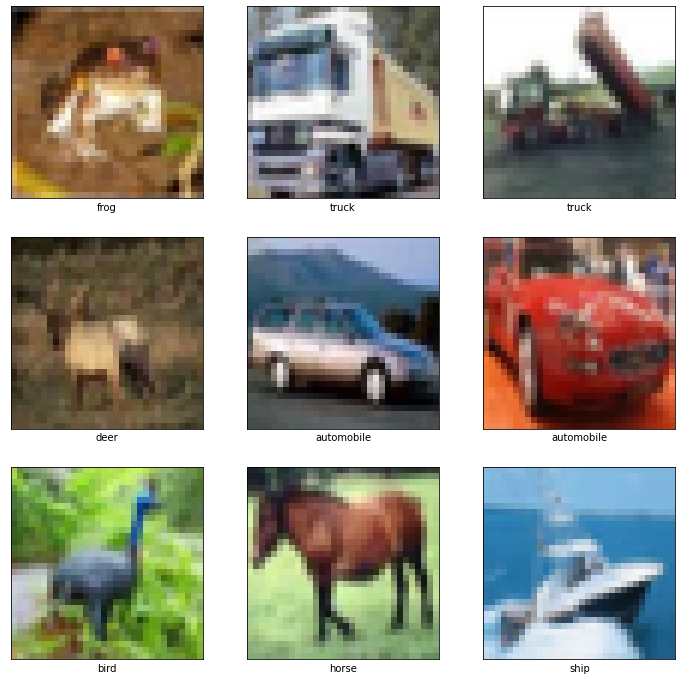

In [8]:
labels_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_img[i], cmap=plt.cm.binary)
    
    plt.xlabel(labels_list[train_labels[i][0]])
plt.show()

In [9]:
print("Max Value:", np.max(train_img[0]))
print("Min Value:", np.min(train_img[0]))

Max Value: 255
Min Value: 0


Since the images are store as pixel values, it makes sense that the range is 0-255. Before building the model, it is a good idea to normalize the dataset to be values in between 0-1.

In [10]:
train_img, test_img = train_img / 255.0, test_img / 255.0

### Building the CNN Model

In [14]:
model = keras.models.Sequential()

I will use a common patterm to build the Sequential Model. The input layer will be a 2D Convolutional Layer, followed by a Maximum Pooling Layer. This is the Convolutional process of the NN. After, I will add a Flatten layer, which will flatten the shape to be 1 dimension. Finally, the final two layers will be the standard fully connected layers, with the last layer having 10 neurons for the 10 possible class labels.  

In [15]:
model.add(keras.layers.Conv2D(32, (3,3), strides=(1,1),activation='relu', input_shape=(32,32,3)))
model.add(keras.layers.MaxPool2D((2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(10))

In [16]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                460864    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 462,410
Trainable params: 462,410
Non-trainable params: 0
_________________________________________________________________
None


Since we have 2 or more target labels, and they are integer values, a good loss function is the Sparse Categorical Cross-Entropy. A good optimizer is the ADAM Optimizer. 

In [17]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Compile the model

In [19]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

Training Step

In [20]:
history = model.fit(train_img, train_labels, epochs=30, batch_size=128 )

Epoch 1/30
391/391 [==============================] - 7s 19ms/step - loss: 1.5717 - accuracy: 0.4396
Epoch 2/30
391/391 [==============================] - 7s 19ms/step - loss: 1.2521 - accuracy: 0.5611
Epoch 3/30
391/391 [==============================] - 7s 19ms/step - loss: 1.1401 - accuracy: 0.6009
Epoch 4/30
391/391 [==============================] - 8s 20ms/step - loss: 1.0598 - accuracy: 0.6307
Epoch 5/30
391/391 [==============================] - 7s 19ms/step - loss: 1.0080 - accuracy: 0.6511
Epoch 6/30
391/391 [==============================] - 7s 19ms/step - loss: 0.9593 - accuracy: 0.6674
Epoch 7/30
391/391 [==============================] - 7s 19ms/step - loss: 0.9219 - accuracy: 0.6799
Epoch 8/30
391/391 [==============================] - 7s 19ms/step - loss: 0.8976 - accuracy: 0.6895
Epoch 9/30
391/391 [==============================] - 8s 19ms/step - loss: 0.8609 - accuracy: 0.7012
Epoch 10/30
391/391 [==============================] - 8s 20ms/step - loss: 0.8278 - accura

Plotting the Loss

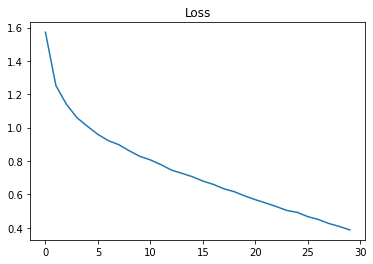

In [21]:
plt.title("Loss")
plt.plot(history.history['loss'])

Evaluate Model

In [24]:
model.evaluate(test_img, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 1.2794 - accuracy: 0.6400


[1.279405117034912, 0.6399999856948853]

One thing I noticed is that training the model took some time. Considering the size of the dataset, and the dimensionality, this may be expected. I also noticed that the Loss decreased slower compared to previous projects. The accuracy of the model on the test data is approx. 62%, not bad but there is much room for improvement. 

For image related tasks, the issue of convergance in a reasonable amount of time is certainly an important issue to address. In this basic implementation of a CNN structure, the model took about 3.5 minutes to train, and based on the Loss graph we can see that it did not fully converge. 

### Transfer Learning

To try and solve the glaring time complexity issue, we can use Transfer Learning, which is using a model that has pre-trained weights. 

Essentially, we can replace the Convolutional Layer and Pooling Layer with the pre-trained set of layers from the transerred model. 

The model I will use ad the backbone of the new Transfer Learning based model is the RedNet50 model. The Redidual Netoworks (ResNet) are networks that use skip connections to generate multiple paths of variable length from input to output in the backpropogation algorithm. Short paths enable the most learning, and longer ones provide residual contributions. The ResNet is useful in situations where different parts of the image have different complexity. The ResNet will be sueful for our specific problem because a lot of these images feaure a specific object, usually with a basic relatively less complex background (check the EDA section).  

Extra Preprocessing using the resnet50 preprocess method

In [26]:
def preprocess(x, y):
    x_new = keras.applications.resnet50.preprocess_input(x)
    y_new = keras.utils.to_categorical(y, 10)
    return x_new, y_new

In [27]:
#reload data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [28]:
x_train, y_train = preprocess(x_train, y_train)
x_test, y_test = preprocess(x_test, y_test)

### Model with ResNet50

In [29]:
input_t = keras.Input(shape=(32, 32, 3))
resnet = keras.applications.ResNet50(include_top=False,
                                        weights="imagenet",
                                        pooling='max',
                                        input_tensor=input_t)

# use the pre-trained weights from the ResNet, saving time and memory.  
for layer in resnet.layers:
    layer.trainable = False

    
# target resolution for images
# the ResNet works best with 224x224 images
# target_res = (224, 224)
    
resnet_model = keras.models.Sequential()
# resnet_model.add(keras.layers.Lambda(lambda image: tf.image.resize(image, target_res)))
resnet_model.add(resnet)
resnet_model.add(keras.layers.Flatten())

# add layer of normalization and dropout layers - prevent possible overfitting
resnet_model.add(keras.layers.BatchNormalization())
resnet_model.add(keras.layers.Dense(256, activation='relu'))
resnet_model.add(keras.layers.Dropout(0.5))
resnet_model.add(keras.layers.BatchNormalization())
resnet_model.add(keras.layers.Dense(128, activation='relu'))
resnet_model.add(keras.layers.Dropout(0.5))
resnet_model.add(keras.layers.BatchNormalization())
resnet_model.add(keras.layers.Dense(64, activation='relu'))
resnet_model.add(keras.layers.Dropout(0.5))
resnet_model.add(keras.layers.BatchNormalization())

resnet_model.add(keras.layers.Dense(10, activation='softmax'))

In [30]:
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop(learning_rate=2e-5)
resnet_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

Training Step

In [31]:
history = resnet_model.fit(x_train, y_train, epochs=10, batch_size=50, validation_data=(x_test, y_test) )

Epoch 1/15
1000/1000 [==============================] - 54s 54ms/step - loss: 2.8204 - accuracy: 0.1237 - val_loss: 2.0765 - val_accuracy: 0.2499
Epoch 2/15
1000/1000 [==============================] - 52s 52ms/step - loss: 2.5536 - accuracy: 0.1644 - val_loss: 1.8883 - val_accuracy: 0.3533
Epoch 3/15
1000/1000 [==============================] - 52s 52ms/step - loss: 2.3294 - accuracy: 0.2099 - val_loss: 1.7494 - val_accuracy: 0.4153
Epoch 4/15
1000/1000 [==============================] - 53s 53ms/step - loss: 2.1858 - accuracy: 0.2474 - val_loss: 1.6452 - val_accuracy: 0.4584
Epoch 5/15
1000/1000 [==============================] - 54s 54ms/step - loss: 2.0582 - accuracy: 0.2827 - val_loss: 1.5642 - val_accuracy: 0.4843
Epoch 6/15
1000/1000 [==============================] - 54s 54ms/step - loss: 1.9649 - accuracy: 0.3125 - val_loss: 1.5022 - val_accuracy: 0.5022
Epoch 7/15
1000/1000 [==============================] - 54s 54ms/step - loss: 1.8790 - accuracy: 0.3394 - val_loss: 1.4462 -

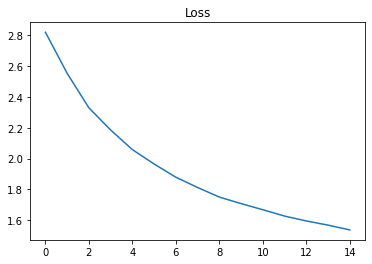

In [32]:
plt.title("Loss")
plt.plot(history.history['loss'])

In [33]:
resnet_model.evaluate(x_test, y_test)

313/313 [==============================] - 11s 37ms/step - loss: 1.2226 - accuracy: 0.5891


[1.2226381301879883, 0.5891000032424927]